# Web Server Log Analytics with Apache Spark

# importing libraries

In [84]:
import os
import sys
import re
import glob
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import Row
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import udf
from pyspark.sql.functions import desc
from pyspark.sql import functions as F
import seaborn as sns

# creating spark session

In [3]:
spark = SparkSession.builder.appName("Python Spark SQL basic example").config("spark.some.config.option", "some-value").getOrCreate()

# reading log data

In [27]:
log_files_df = spark.read.text("NASA_access_log_Aug95.gz")
log_files_df.printSchema()
log_files_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+--------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                     |
+--------------------------------------------------------------------------------------------------------------------------+
|in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839|
|uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0                                                   |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0                          |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0                        |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif H

# using regular exprssions to parse log files

In [14]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
status_pattern = r'\s(\d{3})\s'
content_size_pattern = r'\s(\d+)$'

In [26]:
log_files_df_parsed=log_files_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
log_files_df_parsed.show(10, truncate=True)
print((log_files_df_parsed.count(), len(log_files_df_parsed.columns)))
log_files_df_parsed.printSchema()

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|   in24.inetnebr.com|01/Aug/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        1839|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|                   /|HTTP/1.0|   304|           0|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/ksclogo-m...|HTTP/1.0|   304|           0|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/MOSAIC-lo...|HTTP/1.0|   304|           0|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/USA-logos...|HTTP/1.0|   304|           0|
|ix-esc-ca2-07.ix....|01/Aug/1995:00:00...|   GET|/images/launch-lo...|HTTP/1.0|   200|        1713|
|     uplherc.upl.com|01/Aug/1995:00:00...|   GET|/images/WORLD-log...|HTTP/1.0|   304|    

# handling null values

In [33]:
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import sum as spark_sum
log_files_df_parsed.select([spark_sum(col(c).isNull().cast('integer')).alias(c) for c in log_files_df_parsed.columns]).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       14178|
+----+---------+------+--------+--------+------+------------+



In [34]:
log_files_df_parsed = log_files_df_parsed.na.fill({'content_size': 0})

# handling time stamps

In [41]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

In [42]:
udf_parse_time = udf(parse_clf_time)

log_files_df_parsed_date_format_change = log_files_df_parsed.select('*', udf_parse_time(log_files_df_parsed['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
log_files_df_parsed_date_format_change.show(10, truncate=True)

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|   in24.inetnebr.com|   GET|/shuttle/missions...|HTTP/1.0|   200|        1839|1995-08-01 00:00:01|
|     uplherc.upl.com|   GET|                   /|HTTP/1.0|   304|           0|1995-08-01 00:00:07|
|     uplherc.upl.com|   GET|/images/ksclogo-m...|HTTP/1.0|   304|           0|1995-08-01 00:00:08|
|     uplherc.upl.com|   GET|/images/MOSAIC-lo...|HTTP/1.0|   304|           0|1995-08-01 00:00:08|
|     uplherc.upl.com|   GET|/images/USA-logos...|HTTP/1.0|   304|           0|1995-08-01 00:00:08|
|ix-esc-ca2-07.ix....|   GET|/images/launch-lo...|HTTP/1.0|   200|        1713|1995-08-01 00:00:09|
|     uplherc.upl.com|   GET|/images/WORLD-log...|HTTP/1.0|   304|           0|1995-08-01 00:00:10|


# data analysis 

summary of conten size

In [45]:
content_size_summary_df = log_files_df_parsed_date_format_change.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,1569898
1,mean,17089.225812122826
2,stddev,67954.76392156907
3,min,0
4,max,3421948


frequncy of http status codes

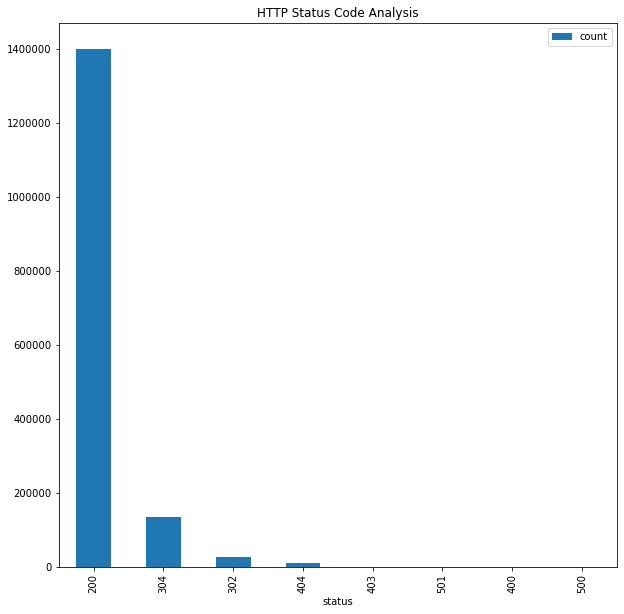

In [95]:
status_freq_df_pandas = log_files_df_parsed_date_format_change.groupBy('status').count().sort(desc('count')).toPandas()
status_freq_df_pandas.plot(x=0,y=1,kind='bar',figsize=(10,10),title="HTTP Status Code Analysis",legend=True)

unique host counts

In [68]:
log_files_df_parsed_date_format_change.select('host').distinct().count()

75029

# http code 404 analysis

count of total 404 responses

In [73]:
df_404 = log_files_df_parsed_date_format_change.filter(F.col("status") == 404)
print(('Total 404 responses: {}').format(df_404.count()))

Total 404 responses: 10056


top 10 endpoints with http 404 status

In [98]:
df_404.groupBy("endpoint").count().sort("count", ascending=False).limit(10).show()

+--------------------+-----+
|            endpoint|count|
+--------------------+-----+
|/pub/winvn/readme...| 1337|
|/pub/winvn/releas...| 1185|
|/shuttle/missions...|  683|
|/images/nasa-logo...|  319|
|/shuttle/missions...|  253|
|/elv/DELTA/uncons...|  209|
|/history/apollo/s...|  200|
|/://spacelink.msf...|  166|
|/images/crawlerwa...|  160|
|/history/apollo/a...|  154|
+--------------------+-----+



top 20 hosts with http 404 status

In [77]:
df_404.groupBy("host").count().sort("count", ascending=False).limit(20).show()

+--------------------+-----+
|                host|count|
+--------------------+-----+
|dialip-217.den.mm...|   62|
|piweba3y.prodigy.com|   47|
|        155.148.25.4|   44|
|        maz3.maz.net|   39|
|       gate.barr.com|   38|
|   m38-370-9.mit.edu|   37|
|ts8-1.westwood.ts...|   37|
| nexus.mlckew.edu.au|   37|
|       204.62.245.32|   37|
|scooter.pa-x.dec.com|   35|
|reddragon.ksc.nas...|   33|
|www-c4.proxy.aol.com|   32|
|piweba5y.prodigy.com|   31|
|www-d4.proxy.aol.com|   30|
|piweba4y.prodigy.com|   30|
|internet-gw.watso...|   29|
|      163.206.104.34|   28|
|         unidata.com|   28|
|                    |   28|
|spica.sci.isas.ac.jp|   27|
+--------------------+-----+



day wise 404 code counts

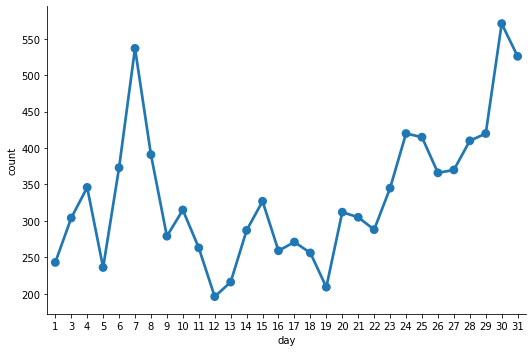

In [94]:
df_404_day_wise=df_404.groupBy(F.dayofmonth('time').alias('day')).count().sort("day").toPandas()
sns.catplot(x='day', y='count', data=df_404_day_wise,kind='point', height=5, aspect=1.5)

hour wise 404 code counts

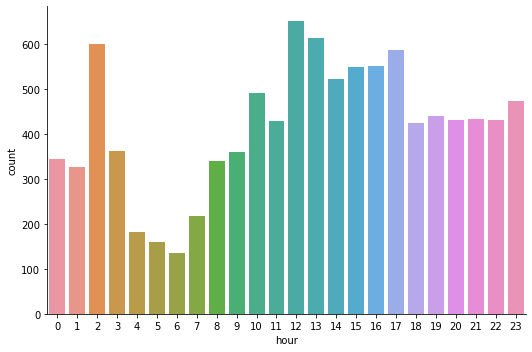

In [92]:
df_404_hour_wise=df_404.groupBy(F.hour('time').alias('hour')).count().sort('hour').toPandas()
sns.catplot(x='hour', y='count', data=df_404_hour_wise, kind='bar', height=5, aspect=1.5,legend_out=True)